Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 37.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.19MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.72MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/20], D Loss: 1.3692, G Loss: 0.4448


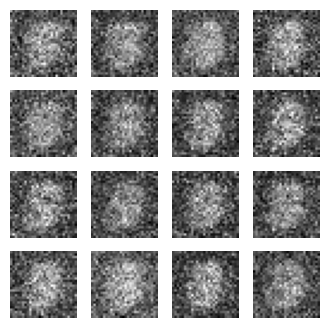

Epoch [2/20], D Loss: 0.6812, G Loss: 1.1712


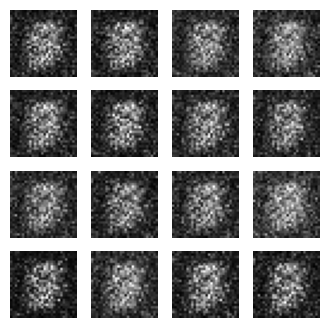

Epoch [3/20], D Loss: 0.7996, G Loss: 1.2253


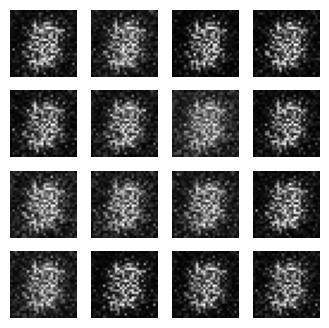

Epoch [4/20], D Loss: 0.9478, G Loss: 1.1346


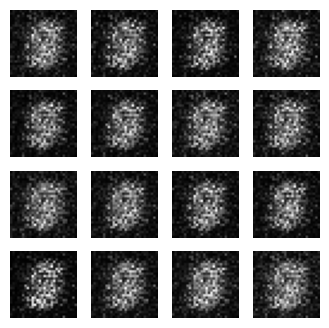

Epoch [5/20], D Loss: 0.8004, G Loss: 1.1373


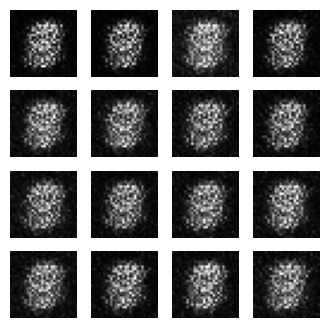

Epoch [6/20], D Loss: 1.0415, G Loss: 1.0239


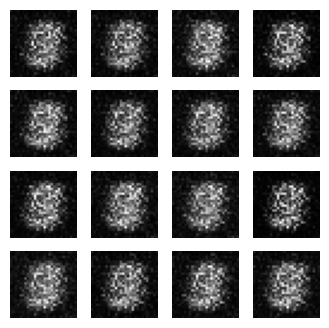

Epoch [7/20], D Loss: 0.6512, G Loss: 1.3849


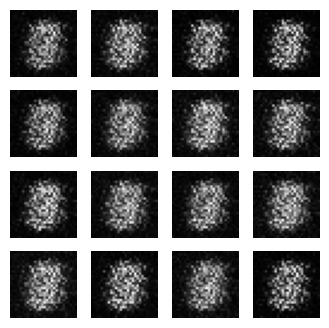

Epoch [8/20], D Loss: 1.0837, G Loss: 0.9514


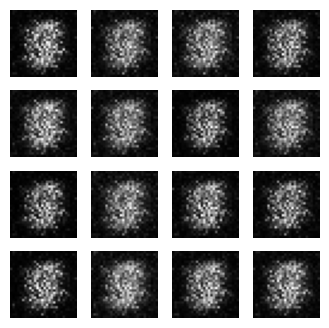

Epoch [9/20], D Loss: 1.2626, G Loss: 0.8421


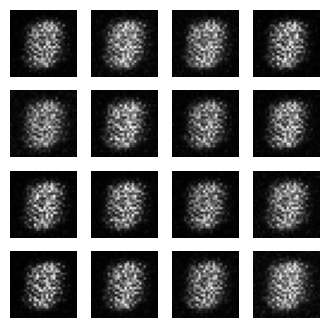

Epoch [10/20], D Loss: 1.1750, G Loss: 0.9053


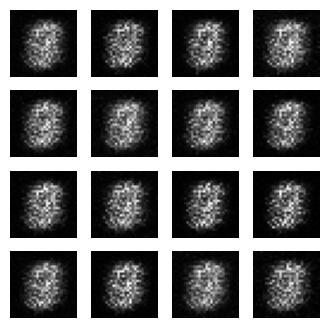

Epoch [11/20], D Loss: 0.6415, G Loss: 1.5673


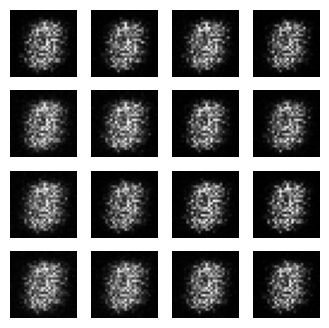

Epoch [12/20], D Loss: 1.2175, G Loss: 1.0775


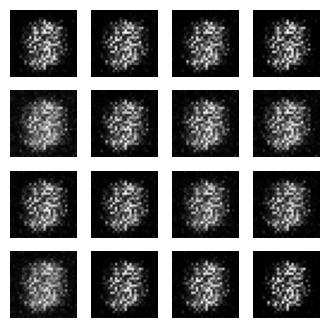

Epoch [13/20], D Loss: 1.0760, G Loss: 1.1639


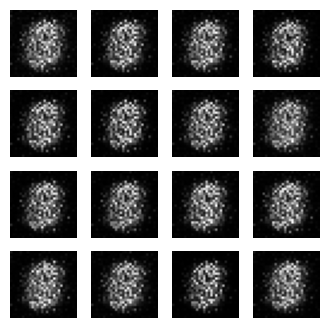

Epoch [14/20], D Loss: 1.3340, G Loss: 0.9056


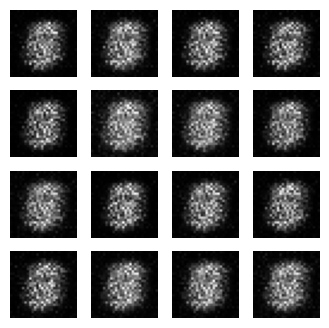

Epoch [15/20], D Loss: 1.1115, G Loss: 0.9202


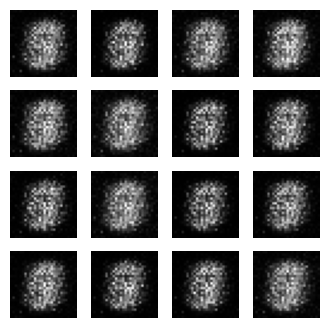

Epoch [16/20], D Loss: 0.9722, G Loss: 1.2623


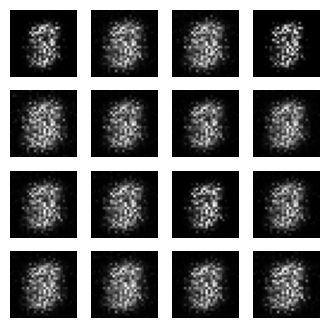

Epoch [17/20], D Loss: 1.0173, G Loss: 1.2777


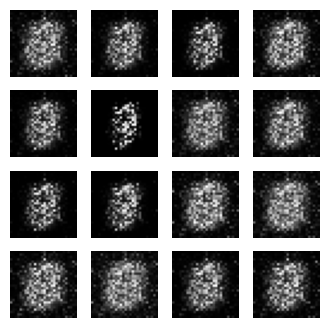

Epoch [18/20], D Loss: 0.8653, G Loss: 1.2525


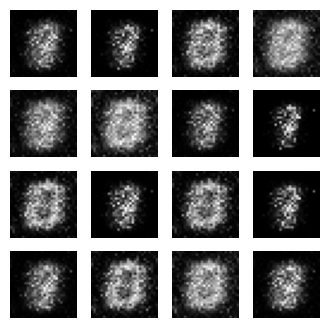

Epoch [19/20], D Loss: 1.1271, G Loss: 1.1288


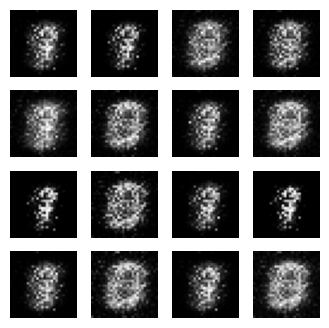

Epoch [20/20], D Loss: 0.9463, G Loss: 1.1089


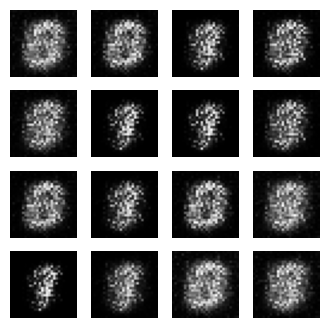

Training complete!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_size = 64
image_size = 28 * 28  # 784
hidden_size = 128
batch_size = 100
num_epochs = 20
lr = 0.0002

# Data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])
mnist = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True)

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
).to(device)

# Generator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
).to(device)

# Loss and optimizers
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=lr)
g_optimizer = optim.Adam(G.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    for images, _ in loader:
        # Flatten and move to device
        images = images.view(-1, image_size).to(device)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)  # Trick D to think fake is real

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    # Print progress
    print(f"Epoch [{epoch + 1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # Generate and display fake images
    with torch.no_grad():
        z = torch.randn(16, latent_size).to(device)
        fake_images = G(z).view(-1, 28, 28).cpu()
        plt.figure(figsize=(4, 4))
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(fake_images[i], cmap='gray')
            plt.axis('off')
        plt.show()

print("Training complete!")

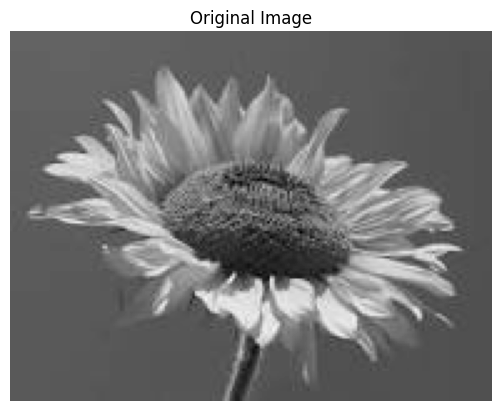

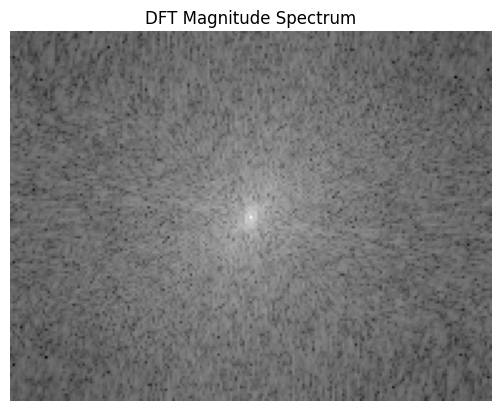

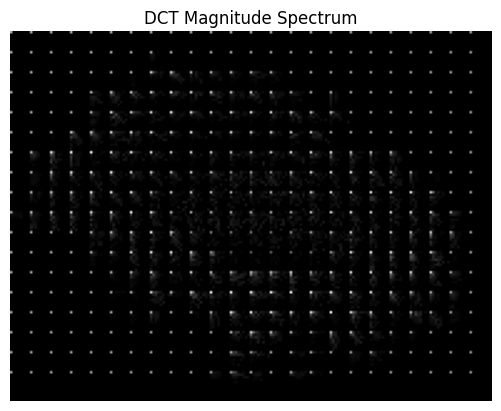

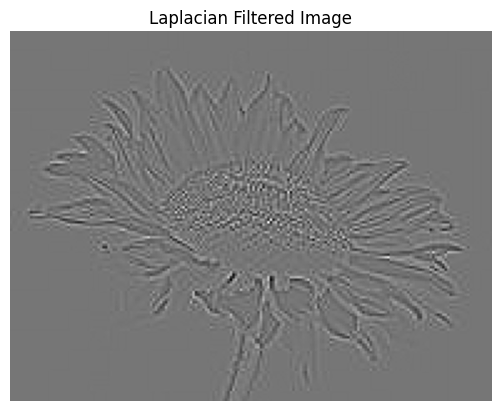

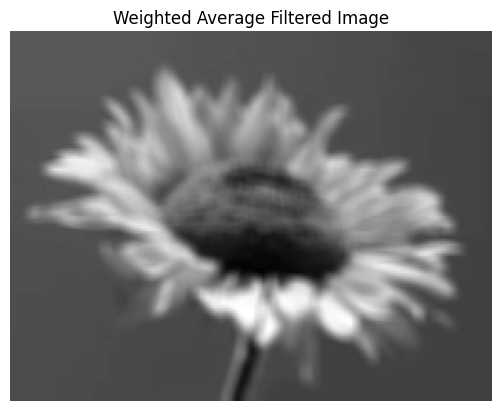

In [7]:
import cv2
import numpy as np
from scipy.fftpack import dct
import matplotlib.pyplot as plt
from PIL import Image

def display_image(title, image):
    """Helper function to display images."""
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()


def compute_dft(image):
    """Compute and display the DFT magnitude spectrum."""
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * \
        np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]) + 1)
    display_image("DFT Magnitude Spectrum", magnitude_spectrum)


def apply_dct(image_array):
    """Apply block-wise DCT to the image."""
    block_size = 8  # Typically 8x8 blocks are used for DCT
    h, w = image_array.shape  # Get height and width

    dct_image = np.zeros_like(image_array)

    # Apply DCT block by block
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image_array[i:i + block_size, j:j + block_size]
            if block.shape[0] != block_size or block.shape[1] != block_size:
                continue  # Skip blocks that are incomplete
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
            dct_image[i:i + block_size, j:j + block_size] = dct_block

    return dct_image


def compute_dct(image):
    """Compute and display the DCT magnitude spectrum."""
    # Ensure grayscale image
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Normalize image to float range [0, 1]
    image = np.float32(image) / 255.0

    # Apply DCT
    dct_image = apply_dct(image)

    # Visualize the DCT magnitude spectrum
    magnitude_spectrum = np.log(np.abs(dct_image) + 1)
    display_image("DCT Magnitude Spectrum", magnitude_spectrum)
def apply_laplacian(image):
    """Apply the Laplacian filter to the image."""
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    display_image("Laplacian Filtered Image", laplacian)


def apply_weighted_average(image):
    """Apply a weighted average (smoothing) filter to the image."""
    kernel = np.ones((5, 5), np.float32) / 25
    smoothed = cv2.filter2D(image, -1, kernel)
    display_image("Weighted Average Filtered Image", smoothed)
image_path = "/content/sunflower.jpeg"  # Replace with your image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
display_image("Original Image", image)

# Perform tasks
compute_dft(image)
compute_dct(image)
apply_laplacian(image)
apply_weighted_average(image)